In [23]:
import cv2
import os
import json
import sqlite3
from matplotlib import pyplot as plt

# Create folders if not already created
os.makedirs("uploaded", exist_ok=True)
os.makedirs("answer_keys", exist_ok=True)

In [171]:
def detect_bubbles(image_path, show=False):
    img = cv2.imread(image_path, 0)
    if img is None:
        raise ValueError("Image not found or unreadable.")

    blurred = cv2.GaussianBlur(img, (7, 7), 0)
    blurred = cv2.GaussianBlur(img_gray, (7, 7), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bubbles = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 250 < area < 600:
            x, y, w, h = cv2.boundingRect(cnt)
            bubbles.append((x, y, w, h))
    bubbles = sorted(bubbles, key=lambda b: (b[0], b[1]))  # sort top to bottom, left to right
    print(f"✅ Detected {len(bubbles)} bubbles")

    if show:
        img_color = cv2.imread(image_path)
        for (x, y, w, h) in bubbles:
            cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
        plt.title("Detected Bubbles")
        plt.axis('off')
        plt.show()

    return bubbles

In [172]:
import os
print(os.listdir("uploaded"))

['Img1.jpeg', 'Img10.jpeg', 'Img11.jpeg', 'Img12.jpeg', 'Img13.jpeg', 'Img14.jpeg', 'Img15.jpeg', 'Img16.jpeg', 'Img17.jpeg', 'Img18.jpeg', 'Img19.jpeg', 'Img2.jpeg', 'Img20.jpeg', 'Img21.jpeg', 'Img22.jpeg', 'Img23.jpeg', 'Img3.jpeg', 'Img4.jpeg', 'Img5.jpeg', 'Img6.jpeg', 'Img7.jpeg', 'Img8.jpeg', 'Img9.jpeg']


✅ Detected 108 bubbles


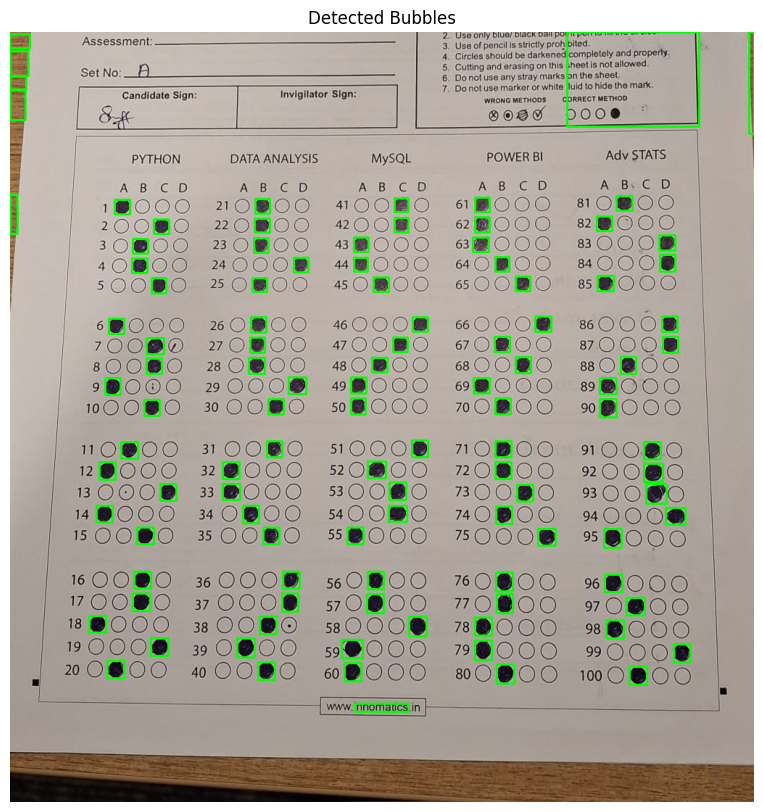

In [173]:
bubbles = detect_bubbles("uploaded/img3.jpeg", show=True)

In [183]:
def is_marked(img, bubble):
    x, y, w, h = bubble
    roi = img[y:y+h, x:x+w]
    filled_pixels = cv2.countNonZero(roi)
    total_pixels = roi.size
    fill_ratio = filled_pixels / total_pixels
    return fill_ratio > 0.5

In [184]:
img_gray = cv2.imread("uploaded/img3.jpeg", 0)
marked_bubbles = []

for i, bubble in enumerate(bubbles):
    if is_marked(img_gray, bubble):
        marked_bubbles.append(i+1)

print(f"✅ Marked bubbles: {marked_bubbles}")

✅ Marked bubbles: []


In [185]:
def map_bubbles_to_questions(bubbles):
    question_map = {}
    group_size = 4  # 5 options per question

    # Group bubbles into vertical sets
    for i in range(0, len(bubbles), group_size):
        
        q_no = (i // group_size) + 1
        options = ['A', 'B', 'C', 'D',]
        vertical_group = sorted(bubbles[i:i+group_size], key=lambda b: b[1])  # sort top to bottom
        question_map[q_no] = dict(zip(options, vertical_group))
    return question_map

In [186]:
def get_marked_answers(img, question_map):
    marked = {}
    for q_no, options in question_map.items():
        for opt, bubble in options.items():
            if is_marked(img, bubble):
                marked[q_no] = opt
                break  # only one option per question
    return marked

In [187]:
def load_answer_key(set_name):
    path = f"answer_keys/{set_name}.json"
    with open(path, "r") as f:
        return json.load(f)

answer_key = load_answer_key("set_a")
print("✅ Loaded answer key")

✅ Loaded answer key


In [188]:
def evaluate_answers(marked_answers, answer_key):
    score = 0
    subject_scores = {}

    for subject, answers in answer_key.items():
        correct = 0
        for q_no, correct_opt in answers.items():
            try:
                q_no_int = int(q_no)
                if q_no_int in marked_answers:
                    if marked_answers[q_no_int] == correct_opt:
                        correct += 1
            except Exception as e:
                print(f"⚠ Error comparing Q{q_no}: {e}")
        subject_scores[subject] = correct
        score += correct

    print("✅ Subject-wise Scores:", subject_scores)
    return score, subject_scores

In [189]:
def visualize_bubbles(image_path, bubbles):
    img_color = cv2.imread(image_path)
    for i, (x, y, w, h) in enumerate(bubbles):
        cv2.rectangle(img_color, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img_color, str(i+1), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.title("Bubble Index Overlay")
    plt.axis('off')
    plt.show()

In [190]:
# Manually map Q1 (adjust indexes if needed)
question_map = {
    1: {
        'A': bubbles[0],
        'B': bubbles[1],
        'C': bubbles[2],
        'D': bubbles[3]
    }
}

marked_answers = get_marked_answers_debug(img_gray, question_map)


🔎 Q1:
  Option A: fill ratio = 1.00
  Option B: fill ratio = 1.00
  Option C: fill ratio = 1.00
  Option D: fill ratio = 1.00
✅ Marked: A


✅ Detected 108 bubbles


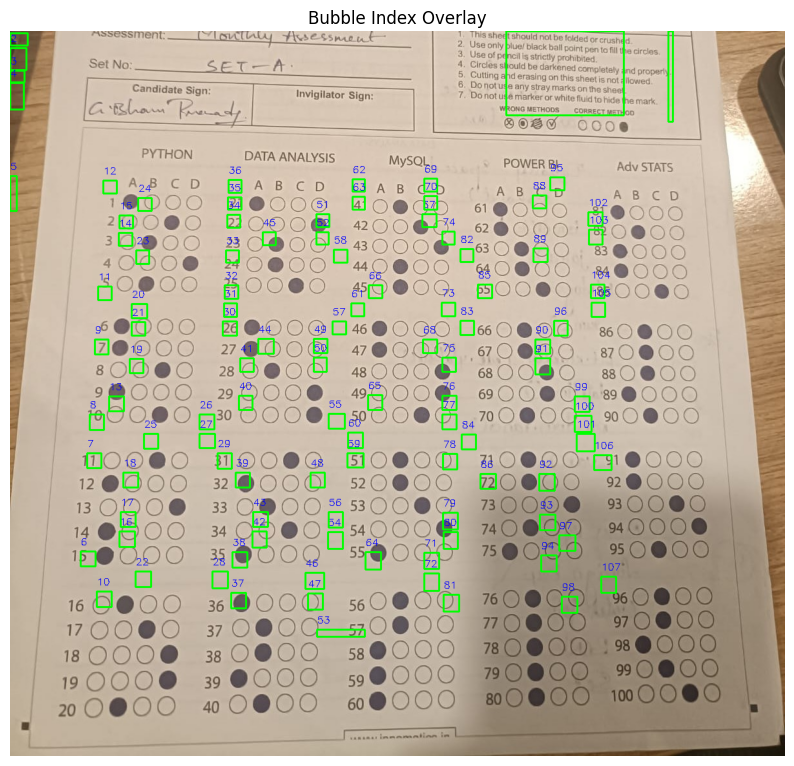

✔ Marked Answers: {}
Q1: Detected=None, Correct=A
Q2: Detected=None, Correct=C
Q3: Detected=None, Correct=C
Q4: Detected=None, Correct=C
Q5: Detected=None, Correct=C
Q6: Detected=None, Correct=C
Q7: Detected=None, Correct=A
Q8: Detected=None, Correct=A
Q9: Detected=None, Correct=A
Q10: Detected=None, Correct=A
Q11: Detected=None, Correct=A
Q12: Detected=None, Correct=A
Q13: Detected=None, Correct=A
Q14: Detected=None, Correct=A
Q15: Detected=None, Correct=B
Q16: Detected=None, Correct=A,B,C,D
Q17: Detected=None, Correct=A
Q18: Detected=None, Correct=A
Q19: Detected=None, Correct=A
Q20: Detected=None, Correct=B
Q21: Detected=None, Correct=A
Q22: Detected=None, Correct=D
Q23: Detected=None, Correct=D
Q24: Detected=None, Correct=C
Q25: Detected=None, Correct=B
Q26: Detected=None, Correct=A
Q27: Detected=None, Correct=C
Q28: Detected=None, Correct=D
Q29: Detected=None, Correct=B
Q30: Detected=None, Correct=C
Q31: Detected=None, Correct=C
Q32: Detected=None, Correct=D
Q33: Detected=None, Co

In [191]:
img = cv2.imread("uploaded/img1.jpeg", 0)
bubbles = detect_bubbles("uploaded/img1.jpeg")
question_map = map_bubbles_to_questions(bubbles)
visualize_bubbles("uploaded/img1.jpeg", bubbles)
marked_answers = get_marked_answers(img, question_map)
print("✔ Marked Answers:", marked_answers)
for subject, answers in answer_key.items():
    for q_no, correct_opt in answers.items():
        detected = marked_answers.get(int(q_no), "None")
        print(f"Q{q_no}: Detected={detected}, Correct={correct_opt}")

answer_key = load_answer_key("set_a")  # or "set_b"
score, subject_scores = evaluate_answers(marked_answers, answer_key)
print(f"🏆 Total Score: {score}")

In [192]:
def save_result(student_id, score):
    conn = sqlite3.connect("results.db")
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS results (
                        student_id TEXT,
                        score INTEGER)''')
    cursor.execute("INSERT INTO results VALUES (?, ?)", (student_id, score))
    conn.commit()
    conn.close()

    
save_result("Gokulam Randy", score)
print("✅ Result saved to database")

✅ Result saved to database
